# Wizualizacja i przetwarzanie danych geoprzestrzennych za pomocą GeoPandas

## Import bibliotek

In [3]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

## Wczytanie pliku wektorowych danych przestrzennych
Jest to mapa podziału administracyjnego Polski

In [4]:
mapa = geopandas.read_file('data/wojewodztwa.shp', encoding='utf-8')
mapa.head()

,gml_id,JPT_SJR_KO,JPT_POWIER,JPT_KOD_JE,JPT_NAZWA_,JPT_ORGAN_,JPT_JOR_ID,WERSJA_OD,WERSJA_DO,WAZNY_OD,...,JPT_ID,JPT_POWI_1,JPT_KJ_I_3,JPT_GEOMET,JPT_GEOM_1,SHAPE_LENG,SHAPE_AREA,REGON,RODZAJ,geometry
0,None,WOJ,2289315,32,zachodniopomorskie,None,0,20220613,0,20120926,...,1364544,0,None,0,0,12.1323542862,3.10794349875,81168387600000,wojewodztwo,"POLYGON ((188256.168 683730.875, 189761.898 68..."
1,None,WOJ,1398751,08,lubuskie,None,0,20211210,0,20120926,...,1361674,0,None,0,0,11.0914310011,1.83850176383,97789593100000,wojewodztwo,"POLYGON ((249058.528 411232.826, 249030.522 41..."
2,None,WOJ,1994777,02,dolnośląskie,None,0,20221019,0,20120926,...,1365817,0,None,0,0,13.846094171,2.55916927233,93193464400000,wojewodztwo,"POLYGON ((351910.997 289041.305, 351818.002 28..."
3,None,WOJ,2982700,30,wielkopolskie,None,0,20220330,0,20120926,...,1363546,2982700,None,0,0,18.4097920287,3.93220020515,63125781600000,wojewodztwo,"POLYGON ((441690.785 515930.957, 441724.727 51..."
4,None,WOJ,1831001,22,pomorskie,None,0,20220906,0,20120926,...,1365552,0,None,0,0,11.7084107024,2.68945114136,19167483600000,wojewodztwo,"POLYGON ((488665.467 751328.589, 488780.891 75..."


### Wyświetlenie mapy

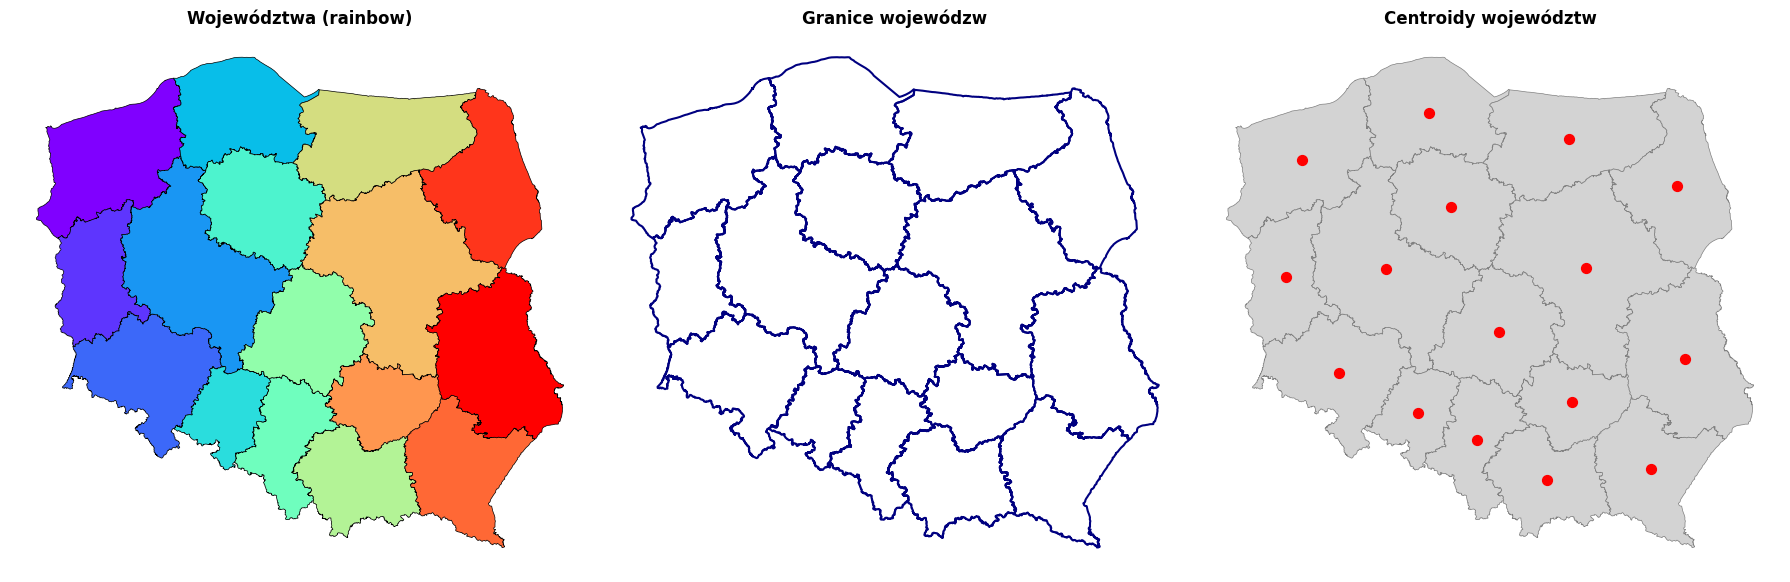

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Mapa z kolorami
mapa.plot(cmap='rainbow', ax=axes[0], edgecolor='black', linewidth=0.5)
axes[0].set_title('Województwa (rainbow)', fontsize=12, fontweight='bold')
axes[0].set_axis_off()

# Granice
mapa.boundary.plot(ax=axes[1], color='navy', linewidth=1.5)
axes[1].set_title('Granice wojewódzw', fontsize=12, fontweight='bold')
axes[1].set_axis_off()

# Centroidy
mapa.plot(ax=axes[2], color='lightgray', edgecolor='gray', linewidth=0.5)
mapa.centroid.plot(ax=axes[2], color='red', markersize=50, marker='o')
axes[2].set_title('Centroidy województw', fontsize=12, fontweight='bold')
axes[2].set_axis_off()

plt.tight_layout()
plt.show()

### 

### Liczenie statystyk

Odległość między centroidami

In [6]:
slaskie_centroid = mapa.loc[mapa['JPT_NAZWA_'].str.contains('śląskie'), 'geometry'].centroid.values[0]
zachodniopomorskie_centroid = mapa.loc[mapa['JPT_NAZWA_'].str.contains('zachodniopomorskie'), 'geometry'].centroid.values[0]

distance = slaskie_centroid.distance(zachodniopomorskie_centroid)
print(f"Odległość między Śląskiem a Zachodniopomorskim: {distance:.2f} m ({distance/1000:.2f} km)")

Odległość między Śląskiem a Zachodniopomorskim: 283849.98 m (283.85 km)


Pole powierzchni, obwód i gęstość (pole/obwód)

In [7]:
mapa['area'] = mapa.geometry.area
mapa['perimeter'] = mapa.geometry.length
mapa['density'] = mapa['area'] / mapa['perimeter']

print("\n=== STATYSTYKI WOJEWÓDZTW ===")
statystyki = mapa[['JPT_NAZWA_', 'area', 'perimeter', 'density']].copy()
statystyki['area_km2'] = (statystyki['area'] / 1_000_000).round(2)
statystyki['perimeter_km'] = (statystyki['perimeter'] / 1000).round(2)
print(statystyki[['JPT_NAZWA_', 'area_km2', 'perimeter_km', 'density']].to_string())

print(f"\nNajwiększe: {mapa.loc[mapa['area'].idxmax(), 'JPT_NAZWA_']}")
print(f"Najmniejsze: {mapa.loc[mapa['area'].idxmin(), 'JPT_NAZWA_']}")


=== STATYSTYKI WOJEWÓDZTW ===
             JPT_NAZWA_  area_km2  perimeter_km       density
0    zachodniopomorskie  22906.24        982.83  23306.508789
1              lubuskie  13989.84        937.36  14924.710219
2          dolnośląskie  19936.13       1172.30  17005.934081
3         wielkopolskie  29797.33       1534.20  19422.026377
4             pomorskie  19522.38        921.39  21188.020400
5              opolskie   9399.95        759.89  12370.217570
6    kujawsko-pomorskie  17947.53       1016.02  17664.510887
7               śląskie  12317.04       1031.40  11942.032528
8               łódzkie  18194.47       1017.42  17882.919526
9           małopolskie  15166.08        980.85  15462.239147
10  warmińsko-mazurskie  24150.67        981.28  24611.304095
11          mazowieckie  35529.17       1670.45  21269.207854
12       świętokrzyskie  11697.23        784.52  14910.131663
13         podkarpackie  17843.70        963.14  18526.513357
14            podlaskie  20193.15      

## Wczytanie danych

In [8]:
dane_bezrobocie = pd.read_excel('data/bezrobocie.xlsx', sheet_name='Tabl.1')

## Obróbka danych

In [9]:
dane_bezrobocie

,"Tablica 1 Liczba bezrobotnych zarejestrowanych oraz stopa bezrobocia według makroregionów, regionów i podregionów",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Table 1. Registered unemployed persons and un...,NaN,NaN,NaN,NaN,NaN,NaN
1,Stan w końcu października 2025 r.,NaN,NaN,NaN,NaN,NaN,NaN
2,As at the end of October 2025,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,Uwaga dot. tablicy 1,NaN,NaN,NaN,NaN,NaN,NaN
109,Dane opracowano według statystycznego podziału...,NaN,NaN,NaN,NaN,NaN,NaN
110,Note to table 1,NaN,NaN,NaN,NaN,NaN,NaN


Zmiana nazw oraz rodzajów zmiennych

In [10]:
dane_bezrobocie = dane_bezrobocie.iloc[9:]
dane_bezrobocie = dane_bezrobocie.rename(columns={
    'Unnamed: 4' : 'Wojewodztwo',
    'Unnamed: 5' : 'Bezrobotni w tys.',
    'Unnamed: 6' : 'Stopa bezrobocia w %',
})
dane_bezrobocie = dane_bezrobocie[['Wojewodztwo', 'Bezrobotni w tys.', 'Stopa bezrobocia w %']]
dane_bezrobocie['Stopa bezrobocia w %'] = (
    dane_bezrobocie['Stopa bezrobocia w %']
    .astype(str).str.replace(',', '.')
    .pipe(pd.to_numeric, errors='coerce')
)

dane_bezrobocie['Bezrobotni w tys.'] = (
    dane_bezrobocie['Bezrobotni w tys.']
    .astype(str).str.replace(',', '.')
    .pipe(pd.to_numeric, errors='coerce')
)
dane_bezrobocie = dane_bezrobocie.reset_index(drop=True)
dane_bezrobocie

,Wojewodztwo,Bezrobotni w tys.,Stopa bezrobocia w %
0,POLSKA ...,867.3,5.6
1,MAKROREGION POŁUDNIOWY,142.4,4.5
2,REGION: Małopolskie,67.2,4.6
3,PODREGION: Miasto Kraków,13.0,2.5
4,PODREGION: Krakowski,11.6,4.2
...,...,...,...
98,NaN,NaN,NaN
99,NaN,NaN,NaN
100,NaN,NaN,NaN
101,NaN,NaN,NaN


Wyciągnięcie tylko województw z danych

In [11]:
dane_bezrobocie = dane_bezrobocie[
    dane_bezrobocie['Wojewodztwo'].str.strip().str.startswith('REGION: ', na=False)
].copy()
dane_bezrobocie

,Wojewodztwo,Bezrobotni w tys.,Stopa bezrobocia w %
2,REGION: Małopolskie,67.2,4.6
9,REGION: Śląskie,75.2,4.3
19,REGION: Wielkopolskie,54.8,3.5
26,REGION: Zachodniopomorskie,43.5,7.4
31,REGION: Lubuskie,19.6,5.5
35,REGION: Dolnośląskie,62.3,5.2
41,REGION: Opolskie,21.1,6.2
45,REGION: Kujawsko-pomorskie,58.1,7.7
51,REGION: Warmińsko-mazurskie,41.8,8.9
55,REGION: Pomorskie,48.9,5.3


Zsumowanie danych do jednego województwa

In [12]:
dane_bezrobocie['Wojewodztwo'] = dane_bezrobocie['Wojewodztwo'].replace({
    '.*Warszawski stołeczny.*': 'REGION: Mazowieckie',
    '.*Mazowiecki regionalny.*': 'REGION: Mazowieckie'
}, regex=True)

dane_bezrobocie = dane_bezrobocie.groupby('Wojewodztwo', as_index=False).sum()
dane_bezrobocie = dane_bezrobocie.reset_index(drop=True)

Usunieńcie przedrostka 'REGION: '

In [13]:
dane_bezrobocie['Wojewodztwo'] = dane_bezrobocie['Wojewodztwo'].str.replace('REGION: ', '')
dane_bezrobocie

,Wojewodztwo,Bezrobotni w tys.,Stopa bezrobocia w %
0,Dolnośląskie,62.3,5.2
1,Kujawsko-pomorskie,58.1,7.7
2,Lubelskie,59.4,7.9
3,Lubuskie,19.6,5.5
4,Małopolskie,67.2,4.6
5,Opolskie,21.1,6.2
6,Podkarpackie,69.7,9.0
7,Podlaskie,31.7,7.3
8,Pomorskie,48.9,5.3
9,Warmińsko-mazurskie,41.8,8.9


Wyczyszczenie nazw województw z znaków białych itp.

In [14]:
dane_bezrobocie['Wojewodztwo'] = dane_bezrobocie['Wojewodztwo'].str.lower()
dane_bezrobocie['Wojewodztwo'] = dane_bezrobocie['Wojewodztwo'].str.replace(r'region:\s*', '', regex=True)
dane_bezrobocie['Wojewodztwo'] = dane_bezrobocie['Wojewodztwo'].str.replace(u'\xa0', ' ')
dane_bezrobocie['Wojewodztwo'] = dane_bezrobocie['Wojewodztwo'].str.strip()
dane_bezrobocie['Wojewodztwo'] = dane_bezrobocie['Wojewodztwo'].str.title()
dane_bezrobocie['Wojewodztwo'].unique()

array(['Dolnośląskie', 'Kujawsko-Pomorskie', 'Lubelskie', 'Lubuskie',
       'Małopolskie', 'Opolskie', 'Podkarpackie', 'Podlaskie',
       'Pomorskie', 'Warmińsko-Mazurskie', 'Wielkopolskie',
       'Zachodniopomorskie', 'Łódzkie', 'Śląskie', 'Świętokrzyskie',
       'Mazowieckie'], dtype=object)

### Połączenie danych z mapą
Selekcja tylko potrzebnych kolumn z GeoDataFrame

In [15]:
mapa = mapa[['JPT_NAZWA_', 'JPT_KOD_JE', 'geometry']]
mapa = mapa.rename(columns={
    'JPT_NAZWA_': 'Wojewodztwo',
    'JPT_KOD_JE': 'Kod_TERYT'
})
mapa['Wojewodztwo'] = mapa['Wojewodztwo'].str.title()
mapa

,Wojewodztwo,Kod_TERYT,geometry
0,Zachodniopomorskie,32,"POLYGON ((188256.168 683730.875, 189761.898 68..."
1,Lubuskie,08,"POLYGON ((249058.528 411232.826, 249030.522 41..."
2,Dolnośląskie,02,"POLYGON ((351910.997 289041.305, 351818.002 28..."
3,Wielkopolskie,30,"POLYGON ((441690.785 515930.957, 441724.727 51..."
4,Pomorskie,22,"POLYGON ((488665.467 751328.589, 488780.891 75..."
5,Opolskie,16,"POLYGON ((410362.99 269639.399, 410366.16 2697..."
6,Kujawsko-Pomorskie,04,"POLYGON ((441690.785 515930.957, 441653.937 51..."
7,Śląskie,24,"MULTIPOLYGON (((559302.978 302887.587, 559268...."
8,Łódzkie,10,"POLYGON ((598629.334 417093.448, 598631.826 41..."
9,Małopolskie,12,"POLYGON ((631316.899 166704.316, 631331.032 16..."


Łączenie geometri wojewódzw z tabelą bezrobocia

In [16]:
mapa_bezrobocia = mapa.merge(dane_bezrobocie, on='Wojewodztwo', how='left')
mapa_bezrobocia

,Wojewodztwo,Kod_TERYT,geometry,Bezrobotni w tys.,Stopa bezrobocia w %
0,Zachodniopomorskie,32,"POLYGON ((188256.168 683730.875, 189761.898 68...",43.5,7.4
1,Lubuskie,08,"POLYGON ((249058.528 411232.826, 249030.522 41...",19.6,5.5
2,Dolnośląskie,02,"POLYGON ((351910.997 289041.305, 351818.002 28...",62.3,5.2
3,Wielkopolskie,30,"POLYGON ((441690.785 515930.957, 441724.727 51...",54.8,3.5
4,Pomorskie,22,"POLYGON ((488665.467 751328.589, 488780.891 75...",48.9,5.3
5,Opolskie,16,"POLYGON ((410362.99 269639.399, 410366.16 2697...",21.1,6.2
6,Kujawsko-Pomorskie,04,"POLYGON ((441690.785 515930.957, 441653.937 51...",58.1,7.7
7,Śląskie,24,"MULTIPOLYGON (((559302.978 302887.587, 559268....",75.2,4.3
8,Łódzkie,10,"POLYGON ((598629.334 417093.448, 598631.826 41...",60.9,6.2
9,Małopolskie,12,"POLYGON ((631316.899 166704.316, 631331.032 16...",67.2,4.6


## Tworzenie wykresu dla połączonych danych

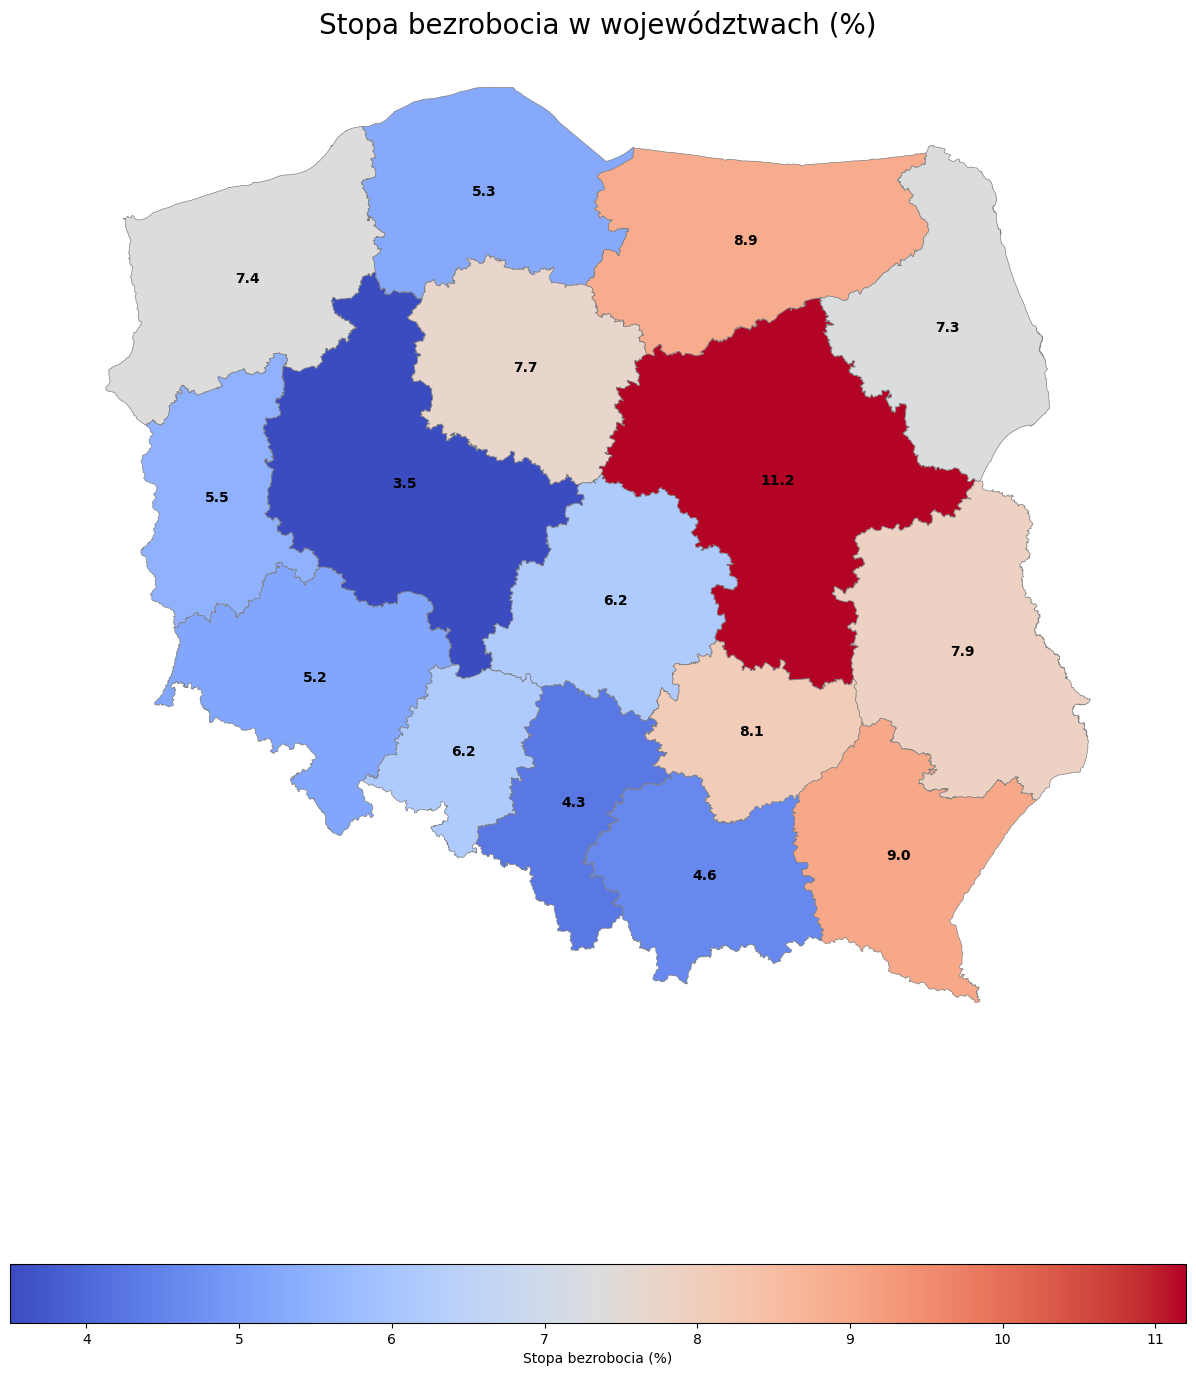

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

mapa_bezrobocia.plot(
    column='Stopa bezrobocia w %',
    ax=ax,
    legend=True,
    legend_kwds={'label': "Stopa bezrobocia (%)", 'orientation': "horizontal", 'shrink': 0.8},
    cmap='coolwarm',
    edgecolor='gray',
    linewidth=0.5
)

for idx, row in mapa_bezrobocia.iterrows():
    wartosc = row['Stopa bezrobocia w %']

    if pd.notna(wartosc):
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y

        ax.annotate(
            text=f"{wartosc:.1f}",
            xy=(x, y),
            ha='center',
            va='center',
            fontsize=10,
            color='black',
            weight='bold'
        )

ax.set_axis_off()
plt.title('Stopa bezrobocia w województwach (%)', fontsize=20)
plt.tight_layout()
plt.show()

Można również dodac prawdziwą mape jako tło

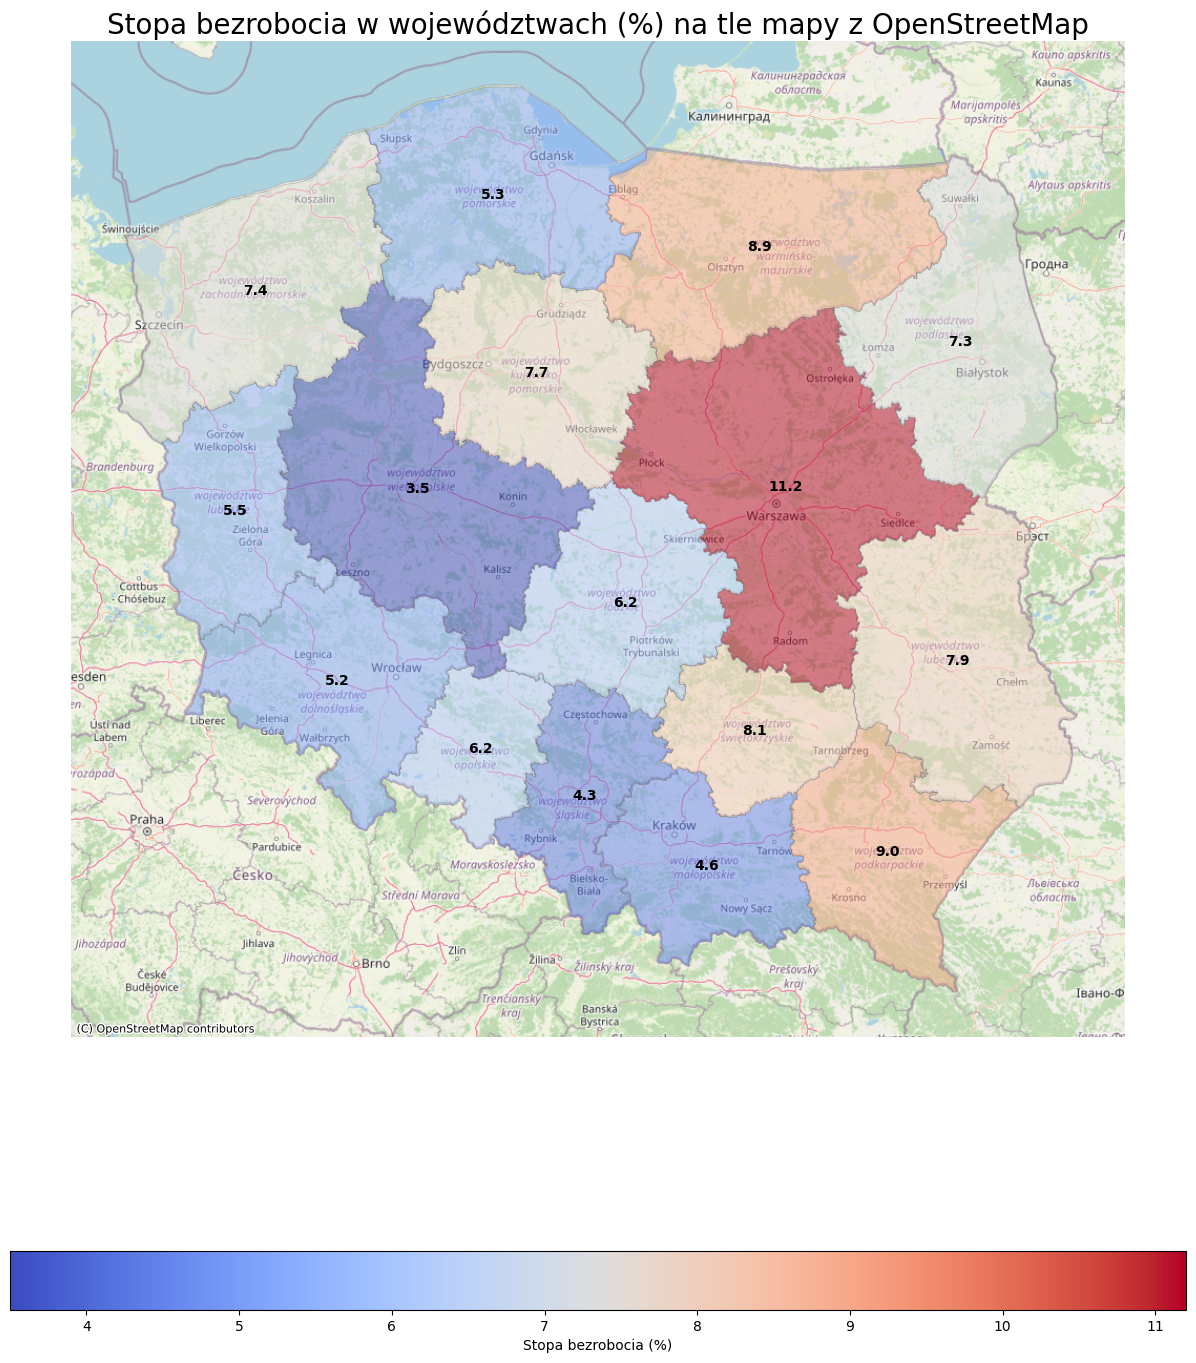

In [18]:
mapa_bezrobocia = mapa_bezrobocia.set_crs(epsg=2180, allow_override=True)
mb3857 = mapa_bezrobocia.to_crs(epsg=3857)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

mb3857.plot(
    column='Stopa bezrobocia w %',
    ax=ax,
    legend=True,
    legend_kwds={'label': "Stopa bezrobocia (%)", 'orientation': "horizontal", 'shrink': 0.8},
    cmap='coolwarm',
    edgecolor='gray',
    linewidth=0.5,
    alpha=0.5
 )

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=mb3857.crs.to_string())

for idx, row in mb3857.iterrows():
    wartosc = row['Stopa bezrobocia w %']
    if pd.notna(wartosc):
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y
        ax.annotate(
            text=f"{wartosc:.1f}",
            xy=(x, y),
            ha='center',
            va='center',
            fontsize=10,
            color='black',
            weight='bold',
        )

ax.set_axis_off()
plt.title('Stopa bezrobocia w województwach (%) na tle mapy z OpenStreetMap', fontsize=20)
plt.tight_layout()
plt.show()

## ZALESIENIE

In [19]:
dane_lasy = pd.read_csv('data/lasy.csv', encoding='utf-8', sep=';')
dane_lasy

,Kod,Nazwa,lasy ogółem;2024;[ha],Unnamed: 3
0,200000,DOLNOŚLĄSKIE,"598542,00",NaN
1,400000,KUJAWSKO-POMORSKIE,"422039,88",NaN
2,600000,LUBELSKIE,"589452,06",NaN
3,800000,LUBUSKIE,"692156,48",NaN
4,1000000,ŁÓDZKIE,"390691,83",NaN
5,1200000,MAŁOPOLSKIE,"434367,76",NaN
6,1400000,MAZOWIECKIE,"831888,41",NaN
7,1600000,OPOLSKIE,"251588,33",NaN
8,1800000,PODKARPACKIE,"685594,97",NaN
9,2000000,PODLASKIE,"631647,13",NaN


In [20]:
dane_lasy = dane_lasy.rename(columns={
    'Nazwa' : 'Wojewodztwo',
    'lasy ogółem;2024;[ha]' : 'Lasy ogółem [ha]'})
dane_lasy = dane_lasy[['Wojewodztwo', 'Lasy ogółem [ha]']]
dane_lasy

,Wojewodztwo,Lasy ogółem [ha]
0,DOLNOŚLĄSKIE,"598542,00"
1,KUJAWSKO-POMORSKIE,"422039,88"
2,LUBELSKIE,"589452,06"
3,LUBUSKIE,"692156,48"
4,ŁÓDZKIE,"390691,83"
5,MAŁOPOLSKIE,"434367,76"
6,MAZOWIECKIE,"831888,41"
7,OPOLSKIE,"251588,33"
8,PODKARPACKIE,"685594,97"
9,PODLASKIE,"631647,13"


In [21]:
dane_lasy['Lasy ogółem [ha]'] = dane_lasy['Lasy ogółem [ha]'].astype(str).str.replace(',', '.').pipe(pd.to_numeric, errors='coerce')
dane_lasy['Wojewodztwo'] = dane_lasy['Wojewodztwo'].str.title()
dane_lasy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Wojewodztwo       16 non-null     object 
 1   Lasy ogółem [ha]  16 non-null     float64
dtypes: float64(1), object(1)
memory usage: 388.0+ bytes


In [31]:
dane_lasy['Lasy [100 tys. ha]'] = (dane_lasy['Lasy ogółem [ha]'] / 100000).round(2)
dane_lasy

,Wojewodztwo,Lasy ogółem [ha],Lasy [100 tys. ha]
0,Dolnośląskie,598542.00,5.99
1,Kujawsko-Pomorskie,422039.88,4.22
2,Lubelskie,589452.06,5.89
3,Lubuskie,692156.48,6.92
4,Łódzkie,390691.83,3.91
5,Małopolskie,434367.76,4.34
6,Mazowieckie,831888.41,8.32
7,Opolskie,251588.33,2.52
8,Podkarpackie,685594.97,6.86
9,Podlaskie,631647.13,6.32


In [32]:
mapa_lasy = mapa.merge(dane_lasy, on='Wojewodztwo', how='left')
mapa_lasy

,Wojewodztwo,Kod_TERYT,geometry,Lasy ogółem [ha],Lasy [100 tys. ha]
0,Zachodniopomorskie,32,"POLYGON ((188256.168 683730.875, 189761.898 68...",823175.31,8.23
1,Lubuskie,08,"POLYGON ((249058.528 411232.826, 249030.522 41...",692156.48,6.92
2,Dolnośląskie,02,"POLYGON ((351910.997 289041.305, 351818.002 28...",598542.00,5.99
3,Wielkopolskie,30,"POLYGON ((441690.785 515930.957, 441724.727 51...",770519.54,7.71
4,Pomorskie,22,"POLYGON ((488665.467 751328.589, 488780.891 75...",669074.14,6.69
5,Opolskie,16,"POLYGON ((410362.99 269639.399, 410366.16 2697...",251588.33,2.52
6,Kujawsko-Pomorskie,04,"POLYGON ((441690.785 515930.957, 441653.937 51...",422039.88,4.22
7,Śląskie,24,"MULTIPOLYGON (((559302.978 302887.587, 559268....",395940.78,3.96
8,Łódzkie,10,"POLYGON ((598629.334 417093.448, 598631.826 41...",390691.83,3.91
9,Małopolskie,12,"POLYGON ((631316.899 166704.316, 631331.032 16...",434367.76,4.34


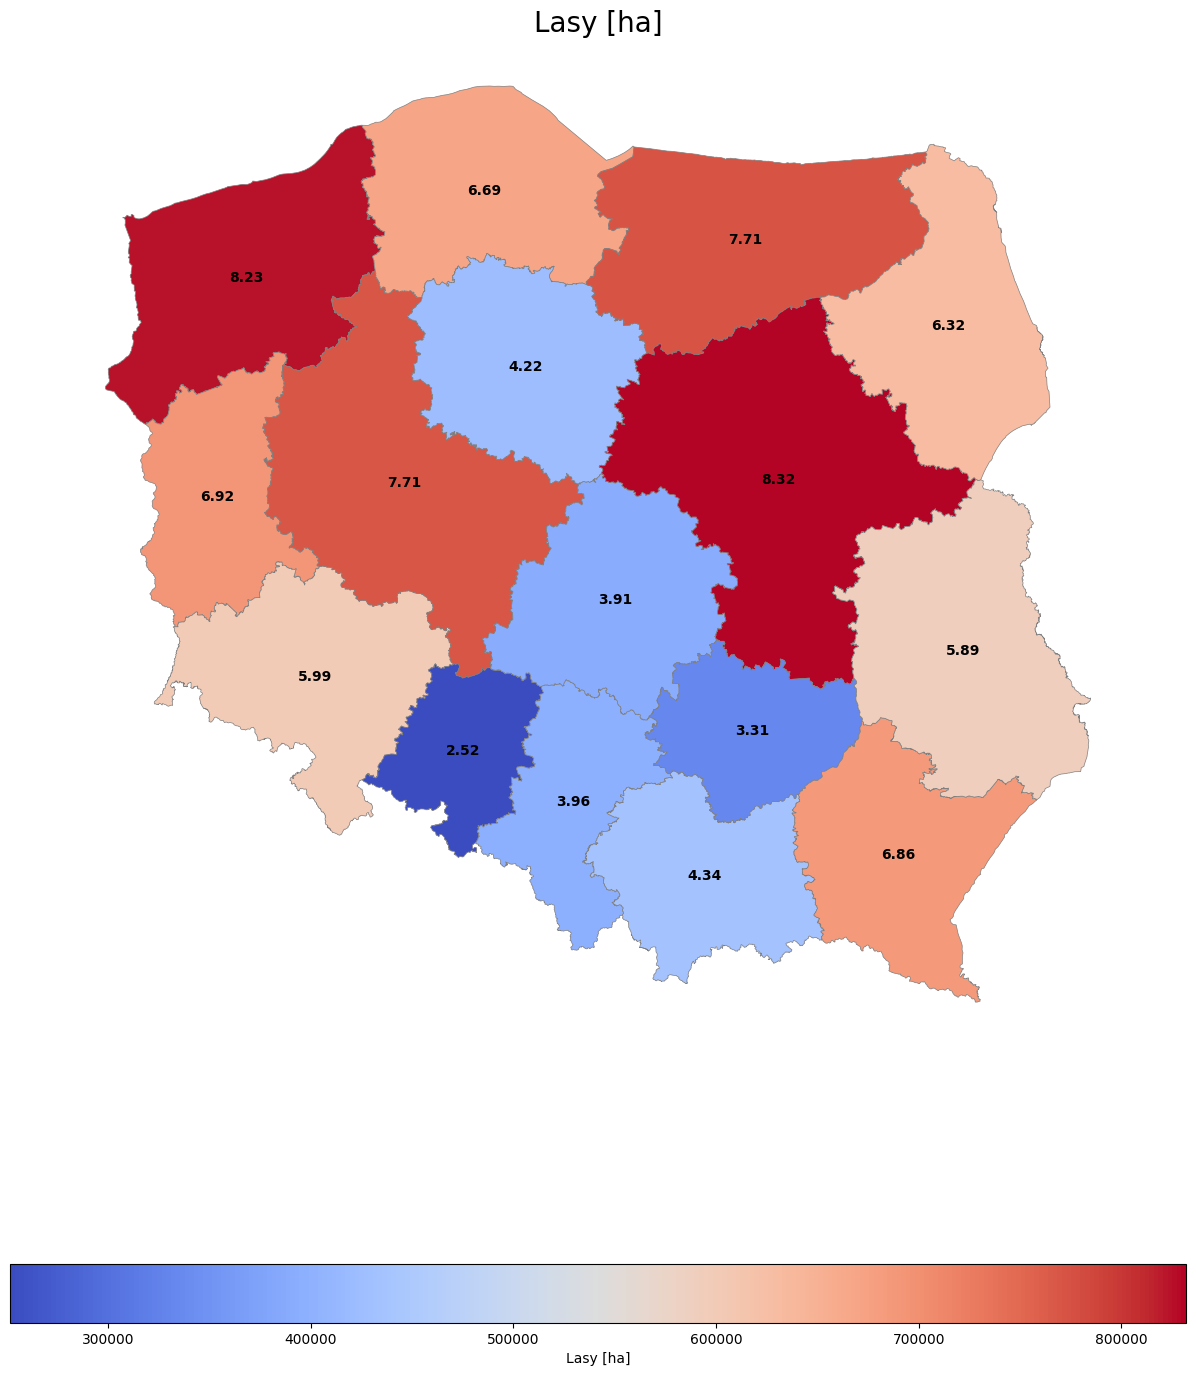

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

mapa_lasy.plot(
    column='Lasy ogółem [ha]',
    ax=ax,
    legend=True,
    legend_kwds={'label': "Lasy [ha]", 'orientation': "horizontal", 'shrink': 0.8},
    cmap='coolwarm',
    edgecolor='gray',
    linewidth=0.5
)

for idx, row in mapa_lasy.iterrows():
    wartosc = row['Lasy [100 tys. ha]']

    if pd.notna(wartosc):
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y

        ax.annotate(
            text=f"{wartosc:.2f}",
            xy=(x, y),
            ha='center',
            va='center',
            fontsize=10,
            color='black',
            weight='bold'
        )

ax.set_axis_off()
plt.title('Lasy [ha]', fontsize=20)
plt.tight_layout()
plt.show()